## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

## Setup

In [ ]:
# !pip install wandb
!pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 31.4MB/s 


In [ ]:
# import wandb
# wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169009152/169001437 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

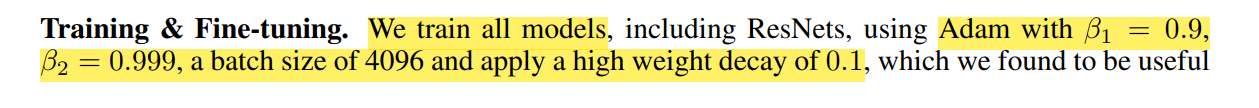

Remember that,
1. Transformer’s sequence length is inversely proportional to the square of the patch size,
thus models with smaller patch size are computationally more expensive.
2. To get the best possible performance on the smaller datasets, we optimize three regularization parameters – weight decay, dropout, and label smoothing.

In [ ]:
learning_rate = 0.003
weight_decay = 0.1
batch_size = 512 
num_epochs = 7 #Changed from 100 to 7
image_size = 72  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12 # Changed from 5 to 12 (Yet to train!)
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 10 #Changed from 13 to 10
mlp_head_units = [3072, 768]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        # Flattening patches
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # Why -1? Check comments of Sayak paul in Henry AI labs tutorial
        return patches

    # Why overriding get-config? ⬇
    # https://stackoverflow.com/questions/58678836/notimplementederror-layers-with-arguments-in-init-must-override-get-conf/58799021
    def get_config(self):

        # config = super().get_config().copy()
        config= {
            'patch_size': self.patch_size,
        }
        
        return config    


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


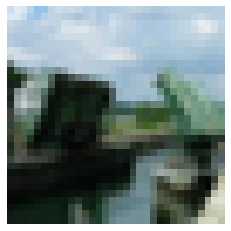

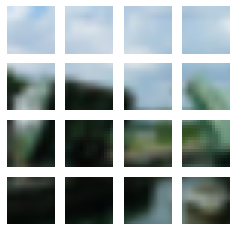

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will **linearly transform** a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        # config = super().get_config().copy()
        config= {
            'num_patches': self.num_patches,
            'projection' : self.projection,
            'position_embedding' : self.position_embedding,
        }
        
        return config         


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

![ViT_Arch](https://lh3.googleusercontent.com/-yo6s2ijtFHAx4ptnRwVL41ORkir6OhH43usNtKvJjVgVuZC6lT7cMsSDZmMXqmapYmL-lDhqi2qIqJmY44Z0rqrAfjHOPC09u5IaRcOg28UW5pBXnFtLvSA_yB6yDYwpwm6Pyqo)


In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)  
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)  
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 768)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 16, 64)       50240       patches[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.predict(x_train).shape

(50000, 100)

## Compile, train, and evaluate the mode

Ran on Cifar-100. No matter how many epochs or parameters initialized, the results are same. <br>**Max accuracy achievable is 70-75%.**

In [ ]:
# wandb.init(project="ImgClassification_ViT")
# wandb_callback = wandb.keras.WandbCallback(log_weights=True)
def run_experiment(model):


    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay, beta_1=0.9, beta_2=0.999
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

  

    # checkpoint_filepath = "checkpoint/cp_ckpt-{epoch:04d}.ckpt"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    #     save_freq=1
    # )
    
    # model.save_weights(checkpoint_path.format(epoch=0))
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[wandb_callback],
    )

    model.save('model-7.h5')

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


epoch,0
loss,4.60993
accuracy,0.01342
top-5-accuracy,0.06069
val_loss,4.60518
val_accuracy,0.0082
val_top-5-accuracy,0.0456
_runtime,39
_timestamp,1619069116
_step,0
best_val_loss,4.60518


epoch,▁
loss,▁
accuracy,▁
top-5-accuracy,▁
val_loss,▁
val_accuracy,▁
val_top-5-accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


Epoch 1/7
88/88 [==============================] - 30s 224ms/step - loss: 4.5351 - accuracy: 0.0283 - top-5-accuracy: 0.1231 - val_loss: 4.4476 - val_accuracy: 0.0188 - val_top-5-accuracy: 0.0892
Epoch 2/7
88/88 [==============================] - 19s 213ms/step - loss: 4.4267 - accuracy: 0.0195 - top-5-accuracy: 0.0972 - val_loss: 4.4654 - val_accuracy: 0.0230 - val_top-5-accuracy: 0.0920
Epoch 3/7
88/88 [==============================] - 19s 213ms/step - loss: 4.4346 - accuracy: 0.0188 - top-5-accuracy: 0.0956 - val_loss: 4.4387 - val_accuracy: 0.0186 - val_top-5-accuracy: 0.0940
Epoch 4/7
88/88 [==============================] - 19s 214ms/step - loss: 4.4393 - accuracy: 0.0196 - top-5-accuracy: 0.0967 - val_loss: 4.4373 - val_accuracy: 0.0198 - val_top-5-accuracy: 0.0956
Epoch 5/7
88/88 [==============================] - 19s 215ms/step - loss: 4.4358 - accuracy: 0.0199 - top-5-accuracy: 0.0965 - val_loss: 4.4254 - val_accuracy: 0.0160 - val_top-5-accuracy: 0.0804
Epoch 6/7
88/88 [===

After 500 epochs, the ViT model achieves around 60% accuracy and
90% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. <mark> To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. </mark>

Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.<mark>
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.</mark>

In [ ]:
# !zip -r model.zip model-1000.h5

  adding: model-500.h5 (deflated 10%)
